In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
import torchvision.models as models
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, EMNIST, CIFAR10,CIFAR100
from PIL import Image
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
# from resnetcifar import ResNet18_cifar10, ResNet50_cifar10
import logging

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs")

In [2]:
class SimpleCNN_header(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=10):
        super(SimpleCNN_header, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # for now, we hard coded this network
        # i.e. we fix the number of hidden layers i.e. 2 layers
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        #self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [3]:
class ModelFedCon(nn.Module):

    def __init__(self, base_model, out_dim, n_classes, net_configs=None):
        super(ModelFedCon, self).__init__()

        if base_model == "resnet50-cifar10" or base_model == "resnet50-cifar100" or base_model == "resnet50-smallkernel" or base_model == "resnet50":
            basemodel = ResNet50_cifar10()
            self.features = nn.Sequential(*list(basemodel.children())[:-1])
            num_ftrs = basemodel.fc.in_features
        elif base_model == "resnet18-cifar10" or base_model == "resnet18":
            basemodel = ResNet18_cifar10()
            self.features = nn.Sequential(*list(basemodel.children())[:-1])
            num_ftrs = basemodel.fc.in_features
        elif base_model == "mlp":
            self.features = MLP_header()
            num_ftrs = 512
        elif base_model == 'simple-cnn':
            self.features = SimpleCNN_header(input_dim=(16 * 5 * 5), hidden_dims=[120, 84], output_dim=n_classes)
            num_ftrs = 84
        elif base_model == 'simple-cnn-mnist':
            self.features = SimpleCNNMNIST_header(input_dim=(16 * 4 * 4), hidden_dims=[120, 84], output_dim=n_classes)
            num_ftrs = 84
            
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

        # last layer
        self.l3 = nn.Linear(out_dim, n_classes)

    def _get_basemodel(self, model_name):
        try:
            model = self.model_dict[model_name]
            #print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        #print("h before:", h)
        #print("h size:", h.size())
        h = h.squeeze()
        #print("h after:", h)
        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)

        y = self.l3(x)
        return h, x, y

In [4]:
def compute_accuracy(model, dataloader, get_confusion_matrix=False, device="cpu", multiloader=False):
    was_training = False
    if model.training:
        model.eval()
        was_training = True

    true_labels_list, pred_labels_list = np.array([]), np.array([])

    correct, total = 0, 0
    if device == 'cpu':
        criterion = nn.CrossEntropyLoss()
    elif device == 'cuda':
        criterion = nn.CrossEntropyLoss().cuda()
    loss_collector = []
    if multiloader:
        for loader in dataloader:
            with torch.no_grad():
                for batch_idx, (x, target) in enumerate(loader):
                    #print("x:",x)
                    #print("target:",target)
                    if device != 'cpu':
                        x, target = x.cuda(), target.to(dtype=torch.int64).cuda()
                    _, _, out = model(x)
                    if len(target)==1:
                        loss = criterion(out, target)
                    else:
                        loss = criterion(out, target)
                    _, pred_label = torch.max(out.data, 1)
                    loss_collector.append(loss.item())
                    total += x.data.size()[0]
                    correct += (pred_label == target.data).sum().item()

                    if device == "cpu":
                        pred_labels_list = np.append(pred_labels_list, pred_label.numpy())
                        true_labels_list = np.append(true_labels_list, target.data.numpy())
                    else:
                        pred_labels_list = np.append(pred_labels_list, pred_label.cpu().numpy())
                        true_labels_list = np.append(true_labels_list, target.data.cpu().numpy())
        avg_loss = sum(loss_collector) / len(loss_collector)
    else:
        with torch.no_grad():
            for batch_idx, (x, target) in enumerate(dataloader):
                #print("x:",x)
                if device != 'cpu':
                    x, target = x.cuda(), target.to(dtype=torch.int64).cuda()
                _,_,out = model(x)
                loss = criterion(out, target)
                _, pred_label = torch.max(out.data, 1)
                loss_collector.append(loss.item())
                total += x.data.size()[0]
                correct += (pred_label == target.data).sum().item()

                if device == "cpu":
                    pred_labels_list = np.append(pred_labels_list, pred_label.numpy())
                    true_labels_list = np.append(true_labels_list, target.data.numpy())
                else:
                    pred_labels_list = np.append(pred_labels_list, pred_label.cpu().numpy())
                    true_labels_list = np.append(true_labels_list, target.data.cpu().numpy())
            avg_loss = sum(loss_collector) / len(loss_collector)

    if get_confusion_matrix:
        conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)

    if was_training:
        model.train()

    if get_confusion_matrix:
        return correct / float(total), conf_matrix, avg_loss

    return correct / float(total), avg_loss

In [5]:
def get_dataloader(dataset, datadir, train_bs, test_bs, dataidxs=None, noise_level=0):
    if dataset in ('cifar10', 'cifar100'):
        if dataset == 'cifar10':
            dl_obj = CIFAR10_truncated

            normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                             std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: F.pad(
                    Variable(x.unsqueeze(0), requires_grad=False),
                    (4, 4, 4, 4), mode='reflect').data.squeeze()),
                transforms.ToPILImage(),
                transforms.ColorJitter(brightness=noise_level),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
            ])
            # data prep for test set
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize])


        train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=False)
        test_ds = dl_obj(datadir, train=False, transform=transform_test, download=False)

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)


    elif dataset == 'tinyimagenet':
        dl_obj = ImageFolder_custom
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        train_ds = dl_obj(datadir+'./train/', dataidxs=dataidxs, transform=transform_train)
        test_ds = dl_obj(datadir+'./val/', transform=transform_test)

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)


    return train_dl, test_dl, train_ds, test_ds

In [6]:
class CIFAR10_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        if torchvision.__version__ == '0.2.1':
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(cifar_dataobj.train_labels)
            else:
                data, target = cifar_dataobj.test_data, np.array(cifar_dataobj.test_labels)
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [7]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.pad(
        Variable(x.unsqueeze(0), requires_grad=False),
        (4, 4, 4, 4), mode='reflect').data.squeeze()),
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
# data prep for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize])

cifar_dataTrain = CIFAR10("../data", True, transform_train, None, True)
cifar_dataTest = CIFAR10("../data", False, transform_test, None, True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.4):
    if dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == 'cifar100':
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == 'tinyimagenet':
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)

    n_train = y_train.shape[0]

    if partition == "homo" or partition == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}


    elif partition == "noniid-labeldir" or partition == "noniid":
        min_size = 0
        min_require_size = 10
        K = 10
        if dataset == 'cifar100':
            K = 100
        elif dataset == 'tinyimagenet':
            K = 200
            # min_require_size = 100

        N = y_train.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                # if K == 2 and n_parties <= 10:
                #     if np.min(proportions) < 200:
                #         min_size = 0
                #         break

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

def load_cifar10_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    cifar10_train_ds = CIFAR10_truncated(datadir, train=True, download=True, transform=transform)
    cifar10_test_ds = CIFAR10_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)
def record_net_data_stats(y_train, net_dataidx_map, logdir):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    data_list=[]
    for net_id, data in net_cls_counts.items():
        n_total=0
        for class_id, n_data in data.items():
            n_total += n_data
        data_list.append(n_total)
    print('mean:', np.mean(data_list))
    print('std:', np.std(data_list))
    logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [9]:


X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts = partition_data(
"cifar10", "../data", "../data", "noniid", 10, beta=0.5)



Files already downloaded and verified
Files already downloaded and verified


INFO:root:Data statistics: {0: {0: 276, 1: 52, 2: 1280, 3: 144, 4: 4, 5: 295, 6: 900, 7: 1537, 8: 142, 9: 1818}, 1: {0: 16, 1: 936, 2: 717, 4: 2312, 5: 7, 6: 188, 7: 40, 8: 436, 9: 288}, 2: {0: 804, 2: 179, 3: 1692, 4: 61, 5: 199, 6: 42, 7: 19, 8: 1583, 9: 338}, 3: {0: 30, 1: 15, 2: 335, 3: 153, 4: 303, 5: 189, 6: 1220, 7: 50, 8: 2032, 9: 1552}, 4: {0: 65, 1: 76, 2: 50, 3: 77, 4: 17, 5: 643, 6: 302, 7: 123, 8: 442, 9: 3}, 5: {0: 889, 1: 189, 2: 1282, 3: 726, 4: 976, 5: 513, 6: 138, 8: 356}, 6: {0: 2, 1: 2546, 2: 633, 3: 111, 4: 440, 5: 175, 6: 25, 7: 300, 8: 8, 9: 1001}, 7: {0: 31, 1: 51, 2: 6, 4: 75, 5: 2037, 6: 93, 7: 2931}, 8: {0: 2073, 1: 1057, 2: 278, 3: 2053}, 9: {0: 814, 1: 78, 2: 240, 3: 44, 4: 812, 5: 942, 6: 2092, 8: 1}}


mean: 5000.0
std: 1160.1166320676555


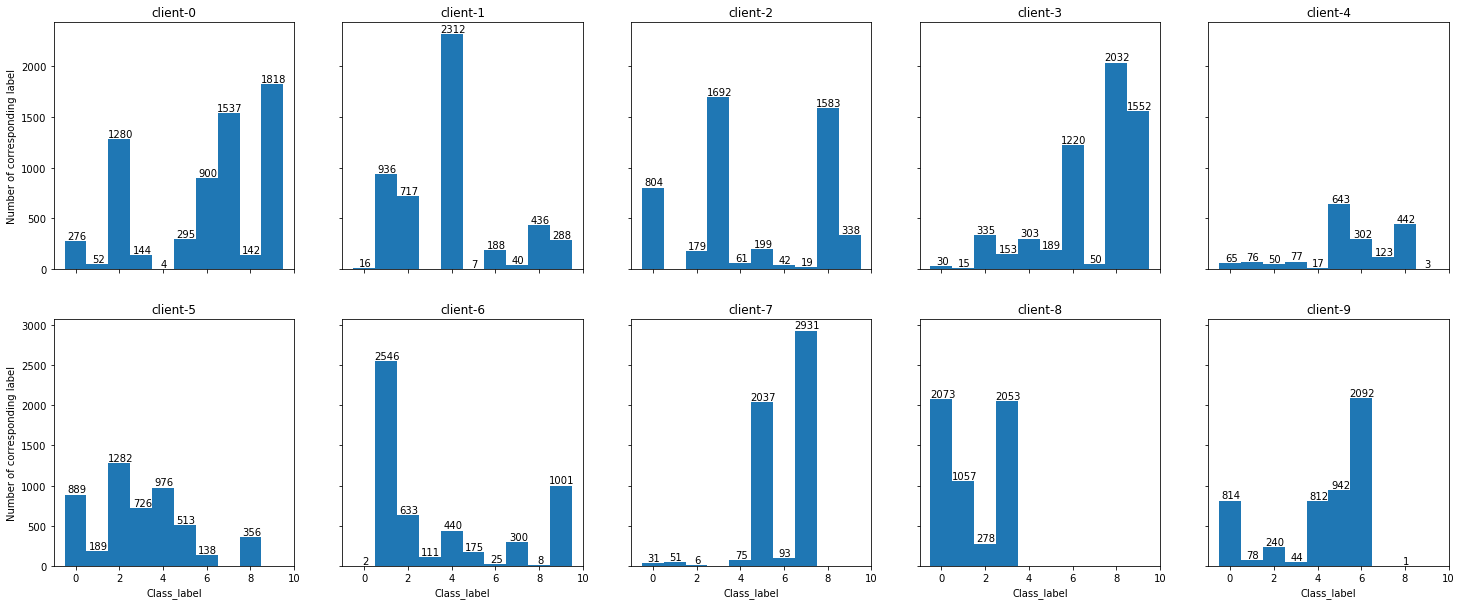

In [10]:

x=traindata_cls_counts
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(25,10))
for i in range(10):
    if i==0:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
    elif i>5:
        ax[i//5,i%5].set_xlabel("Class_label")
    elif i==5:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
        ax[i//5,i%5].set_xlabel("Class_label")
        
    ax[i//5,i%5].set_xlim(-1,10)
    ax[i//5,i%5].bar(list(x[i].keys()),list(x[i].values()),width = 1)
    ax[i//5,i%5].set_title("client-{0}".format(i))
    for m,n in zip(list(x[i].keys()),list(x[i].values())):
        ax[i//5,i%5].text(m+0.05,n+0.05,'%d' %n, ha='center',va='bottom')
plt.show()



In [22]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
cifar_dataobj = CIFAR10("../data", True, transform,download=True)
cifar_dataobj

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [36]:
cifar_dataobj.data.shape

(50000, 32, 32, 3)

In [19]:
net_local = {}
for i in range(10):
    net_local[i] = ModelFedCon("simple-cnn",256,10)
    
net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cpu()
train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", '../data', 64, 32, noise_level=0)

In [20]:
criterion = nn.CrossEntropyLoss()

In [19]:
img = iter(test_dl)
img

In [34]:
# one = next(img)
one[0][0].shape

torch.Size([3, 32, 32])

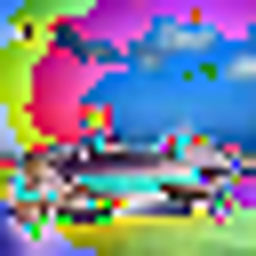

In [45]:
transforms.ToPILImage()(one[0][9]).resize((256,256))

In [13]:
train_dl_local, test_dl_local, _, _ = get_dataloader("cifar10", '../data', 64, 32, dataidxs=net_dataidx_map[0])
next(iter(train_dl_local))

[tensor([[[[ 8.2063e-01, -5.9206e-01, -8.6190e-01,  ...,  1.6302e+00,
             1.9317e+00,  1.1222e+00],
           [ 7.8889e-01, -5.2857e-01, -8.7778e-01,  ...,  1.3921e+00,
             1.7730e+00,  1.0270e+00],
           [ 1.6984e-01, -5.9206e-01, -8.1429e-01,  ...,  1.0270e+00,
             1.2492e+00,  8.5238e-01],
           ...,
           [-1.0000e-01, -2.2698e-01, -2.5873e-01,  ..., -1.7937e-01,
            -2.1111e-01, -3.8571e-01],
           [-5.2381e-02, -6.8254e-02, -3.6508e-02,  ..., -3.0635e-01,
            -3.0635e-01, -3.3810e-01],
           [-1.7937e-01, -8.4127e-02, -1.0000e-01,  ..., -3.5397e-01,
            -4.0159e-01, -2.2698e-01]],
 
          [[ 9.3398e-01, -4.6699e-01, -6.9243e-01,  ...,  1.7069e+00,
             1.9968e+00,  1.2721e+00],
           [ 8.8567e-01, -3.3816e-01, -6.6023e-01,  ...,  1.4332e+00,
             1.8196e+00,  1.1433e+00],
           [ 4.1868e-01, -3.5427e-01, -5.7971e-01,  ...,  1.0306e+00,
             1.3043e+00,  9.0177e-01],


## data

In [142]:
import copy
train_dl_local, test_dl_local, _, _ = get_dataloader("cifar10", './', 64, 32, dataidxs=net_dataidx_map[0])
for idx, (X,Y) in enumerate(train_dl_local):
    
    if idx == 0:
        x0=copy.copy(X)
        y0=copy.copy(Y)
    elif idx == 1:
        x1 = copy.copy(X)
        y1 = copy.copy(Y)
    else:

        break


Files already downloaded and verified
Files already downloaded and verified


In [145]:
y0

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [146]:
y1

tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [143]:
agg = torch.concat((x0,x1))
agg.shape
agg_target = torch.concat((y0,y1))
agg_target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0])

In [147]:
np.unique(agg_target)

array([0, 1])

In [148]:
net0=copy.deepcopy(net_global)
net1=copy.deepcopy(net_global)
net2=copy.deepcopy(net_global)
net3=copy.deepcopy(net_global)
lr=0.01

## all data

In [149]:
_,_,out0 = net0(agg)
loss_0= criterion(out0,agg_target)
loss_0

tensor(2.3328, grad_fn=<NllLossBackward0>)

In [150]:
optimizer_0 = optim.SGD(filter(lambda p: p.requires_grad, net0.parameters()), lr=lr, weight_decay=1e-5)
optimizer_0.zero_grad()
loss_0.backward()
optimizer_0.step()

In [151]:

optimizer_0.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None},
  10: {'momentum_buffer': None},
  11: {'momentum_buffer': None},
  12: {'momentum_buffer': None},
  13: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 1e-05,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

## batch 0

In [72]:
y0

tensor([8, 3, 3, 1, 7, 7, 9, 8, 8, 2, 6, 0, 5, 2, 3, 1, 4, 5, 0, 5, 0, 3, 0, 9,
        2, 7, 5, 7, 0, 7, 7, 5, 4, 0, 6, 3, 4, 8, 6, 6, 4, 5, 6, 4, 3, 8, 8, 1,
        6, 9, 7, 0, 4, 3, 4, 3, 2, 4, 3, 6, 2, 0, 9, 4])

In [73]:
_,_,out1 = net1(x0)
loss_1= criterion(out1,y0)
loss_1

tensor(2.3076, grad_fn=<NllLossBackward0>)

In [74]:
optimizer_1 = optim.SGD(filter(lambda p: p.requires_grad, net1.parameters()), lr=lr, weight_decay=1e-5)
optimizer_1

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
)

## batch 1

In [75]:
y1

tensor([4, 4, 5, 6, 1, 1, 7, 1, 9, 8, 4, 4, 2, 7, 5, 2, 7, 9, 9, 9, 1, 8, 5, 0,
        5, 7, 1, 9, 4, 8, 5, 2, 8, 1, 3, 0, 4, 7, 9, 6, 5, 1, 5, 2, 3, 4, 2, 0,
        5, 2, 4, 5, 9, 7, 3, 3, 8, 3, 7, 7, 6, 7, 9, 9])

In [76]:
_,_,out2 = net2(x1)
loss_2= criterion(out2,y1)
loss_2

tensor(2.2998, grad_fn=<NllLossBackward0>)

In [77]:
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, net2.parameters()), lr=lr,weight_decay=1e-5)
optimizer_2

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
)

## aggregate loss

In [78]:
with torch.no_grad():
    loss = torch.div(loss_1+loss_2,2)
loss

tensor(2.3037)

In [79]:
with torch.no_grad():
    loss_1.set_(loss)
loss_1

tensor(2.3037, grad_fn=<NllLossBackward0>)

In [80]:
with torch.no_grad():
    loss_2.set_(loss)
loss_2

tensor(2.3037, grad_fn=<NllLossBackward0>)

## batch 0 forward

In [81]:
optimizer_1.zero_grad()
loss_1.backward()
optimizer_1.step()
optimizer_1.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None},
  10: {'momentum_buffer': None},
  11: {'momentum_buffer': None},
  12: {'momentum_buffer': None},
  13: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 1e-05,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

## batch 1 forward

In [82]:
optimizer_2.zero_grad()
loss_2.backward()
optimizer_2.step()
optimizer_2.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None},
  10: {'momentum_buffer': None},
  11: {'momentum_buffer': None},
  12: {'momentum_buffer': None},
  13: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 1e-05,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

## compare state_dict()

In [83]:
dis0_1 = []
dis0_2= []
for i in range(14):
    com2 = optimizer_2.state_dict()['state'][i]['momentum_buffer']
    com1 = optimizer_1.state_dict()['state'][i]['momentum_buffer']
    com0 = optimizer_0.state_dict()['state'][i]['momentum_buffer']
    dis0_1.append(sum(com0-com1))
    dis0_2.append(sum(com0-com2))


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [84]:
dis0_1 = []
dis0_2 = []
for key in net0.state_dict().keys():
    dis0_1.append(net0.state_dict()[key]-net1.state_dict()[key])
    dis0_2.append(net0.state_dict()[key]-net2.state_dict()[key])
dis0_1

[tensor([[[[-9.3784e-06, -6.2846e-06,  3.5912e-06,  3.0547e-07, -1.2323e-05],
           [-1.3433e-05, -4.0159e-06,  2.9393e-06, -4.0289e-06, -1.3369e-05],
           [-3.8147e-06,  2.3842e-07,  1.9632e-06, -2.9877e-06, -1.0476e-05],
           [-5.8152e-06, -8.5346e-06, -6.7279e-06, -1.1697e-05, -1.5810e-05],
           [-1.9539e-05, -2.0503e-05, -1.3947e-05, -1.5572e-05, -2.0463e-05]],
 
          [[-1.5494e-05, -1.0408e-05, -3.4999e-06, -9.5516e-06, -2.1249e-05],
           [-2.2464e-05, -1.0602e-05, -5.2806e-06, -1.3702e-05, -2.4626e-05],
           [-1.5517e-05, -1.0032e-05, -8.9332e-06, -1.3128e-05, -2.0817e-05],
           [-1.7881e-05, -1.7792e-05, -1.6645e-05, -2.1446e-05, -2.5537e-05],
           [-3.1643e-05, -3.0100e-05, -2.4565e-05, -2.5049e-05, -2.8379e-05]],
 
          [[-1.1314e-05, -7.7188e-06, -3.2447e-06, -1.0513e-05, -1.9897e-05],
           [-1.7434e-05, -8.6864e-06, -5.7109e-06, -1.4968e-05, -2.3559e-05],
           [-1.2487e-05, -8.9332e-06, -9.7156e-06, -1.5028

## train all in one

In [119]:
# train_dl_global,test_dl,train_ds_global,test_ds
# next(iter(train_dl_global))

In [103]:
# train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
# test_ds = dl_obj(datadir, train=False, transform=transform_test, download=True)

# train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
# test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)

train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", './', 64, 32, noise_level=0)
net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cuda()
op_=optim.Adam(filter(lambda p: p.requires_grad, net_global.parameters()), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().cuda()
loss_li=[]
acc_li = []
epochs = 100
for epoch in range(epochs):
    for idx, (X,Y) in enumerate(train_dl_global):
        X, Y = X.cuda(), Y.cuda()
        X.requires_grad = False
        Y.requires_grad = False
        Y = Y.long()
        
        _,_,out = net_global(X)
        loss_= criterion(out,Y)
        loss_li.append(loss_.data.cpu().numpy())

        op_.zero_grad()
        loss_.backward()
        op_.step()
    test_acc, test_loss = compute_accuracy(net_global, test_dl, device='cuda')
    acc_li.append(test_acc)

In [234]:
# len(loss_li) 781 

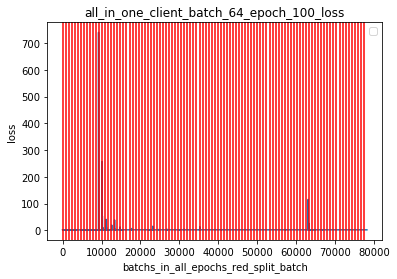

In [104]:
plt.plot(range(len(loss_li)),loss_li,label="_loss_at_all_epochs")
for i in range(100):
    plt.axvline(x=781*i,color='r')
# for i in range(10):
#     plt.plot(range(781),loss_li[781*i:781*i+781],label=str(i)+"_loss_at_all_epochs")
# plt.plot(range(epochs),acc_li,label="epoch_acc",linestyle='dashed')
# plt.plot(range(781),loss_li[781*2:781*2+781],label="_loss_at_all_epochs")
plt.title("all_in_one_client_batch_64_epoch_100_loss")
plt.xlabel("batchs_in_all_epochs_red_split_batch")
plt.ylabel("loss")
plt.legend()
# plt.savefig("./all_in_one_client_batch_64_epoch_100_loss.png",dpi=330)
plt.show()

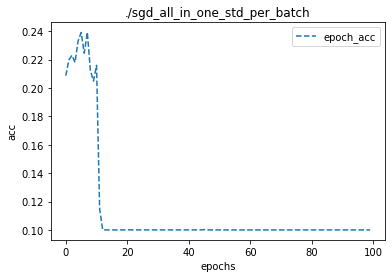

In [106]:
plt.plot(range(epochs),acc_li,label="epoch_acc",linestyle='dashed')
plt.title("all_in_one_client_64_epoch_100_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.title("./sgd_all_in_one_std_per_batch")
# plt.savefig("./all_in_one_client_64_epoch_100_acc.png",dpi=330)
plt.show()

## description about one batch

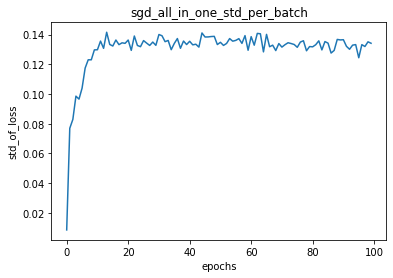

In [167]:
batch_st = []
batch_mi = []
batch_ma = []
for i in range(100):
    mi = np.min(loss_li[781*i:781*i+781])
    ma = np.max(loss_li[781*i:781*i+781])
    st = np.std(loss_li[781*i:781*i+781])
#     print(mi,ma,st)
    batch_mi.append(mi)
    batch_ma.append(ma)
    batch_st.append(st)
# plt.plot(range(10),batch_ma)
# plt.plot(range(10),batch_mi)
plt.plot(range(100),batch_st)
plt.title("sgd_all_in_one_std_per_batch")
plt.xlabel("epochs")
plt.ylabel("std_of_loss")
plt.savefig("./sgd_all_in_one_std_per_batch")
plt.show()

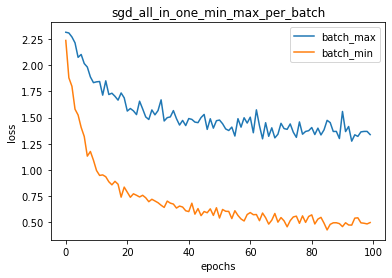

In [168]:
plt.plot(range(100),batch_ma,label='batch_max')
plt.plot(range(100),batch_mi,label='batch_min')
plt.title("sgd_all_in_one_min_max_per_batch")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("./sgd_all_in_one_min_max_per_batch")
plt.legend()
plt.show()

## loop

In [19]:
import copy
n_parties = 10
data_train_per_client_one_batch = {i:{} for i in range(n_parties)}
data_test_per_client_one_batch = {i:{} for i in range(n_parties)}
train_batch_size = 64
test_batch_size = 32

leng = []
for i in range(n_parties):
    train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader("cifar10", './', train_batch_size, test_batch_size, dataidxs=net_dataidx_map[i])
    leng.append(len(train_ds_local)//train_batch_size)
minimum_batch_num = min(leng)
print(minimum_batch_num)

59


In [26]:
lr = 0.01
li_acc = list([] for i in range(n_parties+1))
# one epoch
criterion = nn.CrossEntropyLoss().cuda()
net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cuda()
fed_avg_freqs = [1/train_batch_size for i in range(n_parties)]

nets = [copy.deepcopy(net_global) for i in range(10)]
optimizers = [optim.SGD(filter(lambda p: p.requires_grad, nets[i].parameters()), lr=lr, weight_decay=1e-5) for i in range(n_parties)]
loss = list([] for i in range(minimum_batch_num))
for bat in range(minimum_batch_num):
    for i in range(n_parties):
        train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader("cifar10", './', train_batch_size, test_batch_size, dataidxs=net_dataidx_map[i])

        for idx, (X,Y) in enumerate(train_dl_local):

            if idx == bat:
                data_train_per_client_one_batch[i]['X']=copy.copy(X)
                data_train_per_client_one_batch[i]['Y']=copy.copy(Y)
                break
        for idx, (X,Y) in enumerate(test_dl_local):

            if idx == bat:
                data_test_per_client_one_batch[i]['X']=copy.copy(X)
                data_test_per_client_one_batch[i]['Y']=copy.copy(Y)
                break
        # train
        data_train_per_client_one_batch[i]['X']=data_train_per_client_one_batch[i]['X'].cuda()
        data_train_per_client_one_batch[i]['Y']=data_train_per_client_one_batch[i]['Y'].cuda()
        data_train_per_client_one_batch[i]['X'].requires_grad = False
        data_train_per_client_one_batch[i]['Y'].requires_grad = False
        data_train_per_client_one_batch[i]['Y'] = data_train_per_client_one_batch[i]['Y'].long()
        _,_,out = nets[i](data_train_per_client_one_batch[i]['X'])
        loss_ = criterion(out,data_train_per_client_one_batch[i]['Y'])
        loss[bat].append(loss_.data.cpu().numpy())

        
#         if bat!=0:
#             with torch.no_grad():
#                 loss_.set_(torch.Tensor([sum(loss[bat-1])/10]).cuda())
        
        optimizers[i].zero_grad()
        loss_.backward()
        optimizers[i].step()
        
    print(f"finish one batch on {n_parties} clients,start aggregating")
    global_w = net_global.state_dict()
    for net_id, net in enumerate(nets):
        net_para = net.state_dict()
        if net_id == 0:
            for key in net_para:
                global_w[key] = net_para[key] * fed_avg_freqs[net_id]
        else:
            for key in net_para:
                global_w[key] += net_para[key] *fed_avg_freqs[net_id]
    net_global.load_state_dict(global_w)
    
    # test on local and global
    test_acc, test_loss = compute_accuracy(net_global, test_dl_local, device='cuda')
    li_acc[n_parties].append(test_acc)
    for i in range(n_parties):
        test_acc, test_loss = compute_accuracy(nets[i], test_dl_local, device='cuda')
        li_acc[i].append(test_acc)
    

finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 10 clients,start aggregating
finish one batch on 

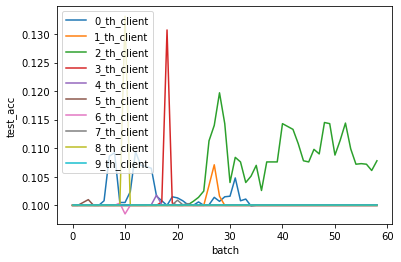

In [27]:
for i in range(10):
    plt.plot(range(minimum_batch_num),li_acc[i],label=str(i)+"_th_client")
plt.xlabel("batch")
plt.ylabel("test_acc")
plt.legend()
# plt.savefig("./acc_per_batch_ten_clients.png")
plt.show()

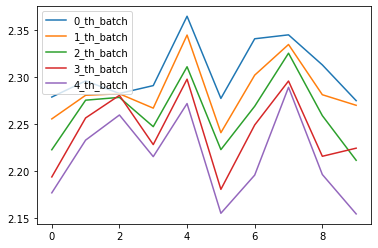

In [28]:
for i in range(5):
    plt.plot(range(10),loss[i*5],label=str(i)+"_th_batch")
plt.legend()
plt.show()

In [232]:
li_acc = []
for i in range(10):
    test_acc, test_loss = compute_accuracy(nets[i], test_dl_global, device='cuda')
    li_acc.append(test_acc)
li_acc

[0.1, 0.1, 0.0999, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

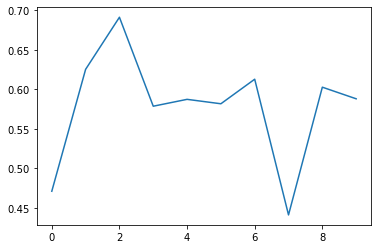

In [211]:
plt.plot(range(10),li_acc)

In [227]:
nets[0].state_dict()['features.conv1.bias']

tensor([-0.0970, -0.0952,  0.0750, -0.0262,  0.0147, -0.0675], device='cuda:0')

In [228]:
nets[1].state_dict()['features.conv1.bias']

tensor([-0.0955, -0.0933,  0.0759, -0.0248,  0.0176, -0.0647], device='cuda:0')

In [229]:
nets[2].state_dict()['features.conv1.bias']

tensor([-0.0965, -0.0945,  0.0747, -0.0252,  0.0161, -0.0663], device='cuda:0')

In [230]:
nets[3].state_dict()['features.conv1.bias']

tensor([-0.0969, -0.0948,  0.0746, -0.0252,  0.0149, -0.0669], device='cuda:0')

In [231]:
nets[4].state_dict()['features.conv1.bias']

tensor([-0.0961, -0.0937,  0.0753, -0.0247,  0.0156, -0.0657], device='cuda:0')

## aggregate the same data, and train all in one 

In [280]:
# normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
#                                  std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: F.pad(
#         Variable(x.unsqueeze(0), requires_grad=False),
#         (4, 4, 4, 4), mode='reflect').data.squeeze()),
#     transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=noise_level),
#     transforms.RandomCrop(32),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     normalize
# ])
# # data prep for test set
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     normalize])

# dl_obj = CIFAR10_truncated

# # train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
# test_ds = dl_obj("./", train=False, transform=transform_test, download=True)

# # train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
# test_dl = data.DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

# cifar_dataobj = CIFAR10("./", True, transform_train, False)
# cifar_dataobj

In [289]:

train_batch_size = 64
test_batch_size = 32
minest_batch_num = 57
n_parties = 10

li_acc = list([] for i in range(n_parties))
data_train_per_client_one_batch = {i:{} for i in range(n_parties)}
data_test_per_client_one_batch = {i:{} for i in range(n_parties)}
# one epoch
criterion = nn.CrossEntropyLoss().cuda()

net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cuda()
nets = [copy.deepcopy(net_global) for i in range(10)]

optimizers = [optim.SGD(filter(lambda p: p.requires_grad, nets[i].parameters()), lr=lr, weight_decay=1e-5) for i in range(n_parties)]
loss = list([] for i in range(minest_batch_num))

agg_dic = {i:{} for i in range(minest_batch_num)}
agg_target_dic = {i:{} for i in range(minest_batch_num)}

for bat in range(minest_batch_num):
    
    for i in range(n_parties):
        train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader("cifar10", './', train_batch_size, test_batch_size, dataidxs=net_dataidx_map[i])

        for idx, (X,Y) in enumerate(train_dl_local):

            if idx == bat:
                data_train_per_client_one_batch[i]['X']=copy.copy(X)
                data_train_per_client_one_batch[i]['Y']=copy.copy(Y)
                break
        for idx, (X,Y) in enumerate(test_dl_local):

            if idx == bat:
                data_test_per_client_one_batch[i]['X']=copy.copy(X)
                data_test_per_client_one_batch[i]['Y']=copy.copy(Y)
                break
                
    x = tuple(data_train_per_client_one_batch[i]['X'] for i in range(n_parties))
    y = tuple(data_train_per_client_one_batch[i]['Y'] for i in range(n_parties))
    agg_dic[bat] = torch.concat(x)
    agg_target_dic[bat] = torch.concat(y)

x = tuple(agg_dic[i] for i in range(minest_batch_num))
y = tuple(agg_target_dic[i] for i in range(minest_batch_num))
agg_57_batch = torch.concat(x)
agg_57_batch_target = torch.concat(y)

TypeError: new(): invalid data type 'str'

In [299]:
# x = tuple(agg_dic[i] for i in range(minest_batch_num))
# y = tuple(agg_target_dic[i] for i in range(minest_batch_num))
# agg_57_batch = torch.concat(x)
# agg_57_batch_target = torch.concat(y)


In [300]:
agg_57_batch[0*64:0*64+64]
# agg_57_batch.shape

torch.Size([36480, 3, 32, 32])

In [301]:
57*640

36480

In [306]:
# train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
# test_ds = dl_obj(datadir, train=False, transform=transform_test, download=True)

# train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
# test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)

train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", './', 64, 32, noise_level=0)

net_agg = ModelFedCon("simple-cnn",256,10)
net_agg = net_agg.cuda()
op_agg=optim.SGD(filter(lambda p: p.requires_grad, net_agg.parameters()), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().cuda()
loss_li_agg=[]
acc_li_agg = []
epochs = 100

for epoch in range(epochs):
    for i in range(570):
        X, Y = agg_57_batch[i*64:i*64+64].cuda(), agg_57_batch_target[i*64:i*64+64].cuda()
        X.requires_grad = False
        Y.requires_grad = False
        Y = Y.long()
        
        _,_,out = net_agg(X)
        loss_agg= criterion(out,Y)
        loss_li_agg.append(loss_agg.data.cpu().numpy())

        op_agg.zero_grad()
        loss_agg.backward()
        op_agg.step()
    test_acc, test_loss = compute_accuracy(net_agg, test_dl, device='cuda')
    acc_li_agg.append(test_acc)

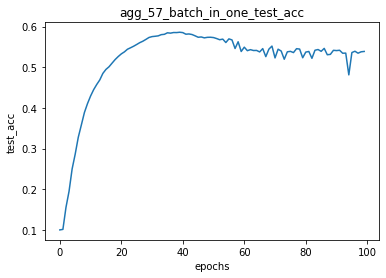

In [307]:
plt.plot(range(epochs),acc_li_agg)
plt.xlabel("epochs")
plt.ylabel("test_acc")
plt.title("agg_57_batch_in_one_test_acc")
plt.savefig("agg_57_batch_in_one_test_acc.png",dpi=330)
plt.show()

## train seperately only one batch


In [18]:
import copy
import collections

In [19]:
n_parties = 10
train_batch_size = 64
test_batch_size = 32
data_train_per_client_one_batch = {i:{} for i in range(n_parties)}
data_test_per_client_one_batch = {i:{} for i in range(n_parties)}

for i in range(n_parties):
    train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader("cifar10", './', train_batch_size, test_batch_size, dataidxs=net_dataidx_map[i])

    for idx, (X,Y) in enumerate(train_dl_local):

        if idx == 0:
            data_train_per_client_one_batch[i]['X']=copy.copy(X)
            data_train_per_client_one_batch[i]['Y']=copy.copy(Y)
            break
    for idx, (X,Y) in enumerate(test_dl_local):

        if idx == 0:
            data_test_per_client_one_batch[i]['X']=copy.copy(X)
            data_test_per_client_one_batch[i]['Y']=copy.copy(Y)
            break

x = tuple(data_train_per_client_one_batch[i]['X'] for i in range(n_parties))
y = tuple(data_train_per_client_one_batch[i]['Y'] for i in range(n_parties))
agg = torch.concat(x)
agg_target = torch.concat(y)
display(agg.shape,agg_target)


torch.Size([640, 3, 32, 32])

tensor([5, 4, 1, 0, 0, 5, 5, 0, 0, 2, 5, 4, 5, 5, 5, 2, 1, 2, 0, 0, 5, 5, 3, 5,
        4, 0, 4, 5, 0, 2, 2, 5, 2, 5, 0, 1, 0, 4, 5, 5, 5, 5, 0, 5, 2, 1, 5, 2,
        1, 4, 0, 0, 0, 0, 5, 5, 5, 5, 5, 0, 5, 1, 2, 0, 1, 9, 8, 0, 2, 8, 2, 2,
        9, 1, 9, 1, 1, 0, 9, 6, 2, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 0, 9, 0, 9,
        9, 9, 9, 9, 2, 8, 8, 9, 9, 7, 0, 9, 9, 9, 9, 9, 1, 9, 8, 1, 9, 2, 1, 1,
        1, 9, 9, 0, 1, 1, 2, 9, 1, 9, 1, 9, 1, 2, 1, 8, 1, 7, 7, 0, 9, 9, 7, 1,
        5, 9, 7, 7, 7, 7, 9, 8, 0, 1, 5, 7, 7, 5, 7, 7, 9, 2, 1, 8, 8, 9, 8, 7,
        7, 7, 7, 9, 9, 9, 6, 9, 8, 5, 9, 7, 9, 5, 9, 5, 7, 4, 7, 7, 8, 1, 7, 9,
        2, 6, 0, 0, 0, 8, 3, 0, 3, 8, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 3, 0, 5, 8,
        0, 0, 0, 0, 0, 8, 0, 3, 0, 3, 3, 0, 0, 0, 6, 3, 0, 3, 3, 0, 0, 0, 3, 0,
        0, 3, 8, 8, 0, 3, 8, 3, 8, 0, 0, 5, 0, 0, 0, 0, 4, 0, 6, 4, 6, 4, 4, 1,
        3, 6, 0, 6, 6, 4, 6, 1, 6, 1, 3, 4, 4, 2, 4, 3, 0, 6, 6, 4, 4, 4, 6, 6,
        1, 4, 6, 4, 4, 6, 6, 6, 4, 6, 6,

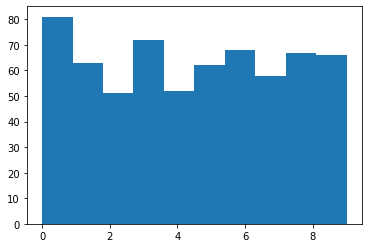

In [22]:
plt.hist(list(agg_target.numpy()))
plt.show()

In [24]:

collections.Counter(list(agg_target.numpy()))

Counter({5: 62, 4: 52, 1: 63, 0: 81, 2: 51, 3: 72, 9: 66, 8: 67, 6: 68, 7: 58})

In [63]:
lr = 0.01
net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cuda()
criterion = nn.CrossEntropyLoss().cuda()

net0 = copy.deepcopy(net_global)
optimizer0=optim.SGD(filter(lambda p: p.requires_grad, net0.parameters()), lr=lr, weight_decay=1e-5)
nets = [copy.deepcopy(net_global) for i in range(10)]
optimizers = [optim.SGD(filter(lambda p: p.requires_grad, nets[i].parameters()), lr=lr, weight_decay=1e-5) for i in range(10)]


In [64]:
n_parties = 10
epochs = 500
loss = list([] for i in range(11))

for i in range(epochs):
    loss_collector = []
    for j in range(n_parties):
        _,_,out = nets[j](data_train_per_client_one_batch[j]['X'].cuda())
        loss_ = criterion(out,data_train_per_client_one_batch[j]['Y'].cuda())
        loss[j].append(loss_.data.cpu().numpy())
        
#         with torch.no_grad():
#             loss_.set_(torch.Tensor(loss[j]))
        
        optimizers[j].zero_grad()
        loss_.backward()
        optimizers[j].step()
        
    _,_,out0 = net0(agg.cuda())
    loss0= criterion(out0,agg_target.cuda())
    loss[10].append(loss0.data.cpu().numpy())
    
    optimizer0.zero_grad()
    loss0.backward()
    optimizer0.step()

## train aggregation

In [97]:
for i in range(500):
    _,_,out0 = net0(agg.cuda())
    loss0= criterion(out0,agg_target.cuda())
    loss[10].append(loss0.data.cpu().numpy())
    
    optimizer0.zero_grad()
    loss0.backward()
    optimizer0.step()


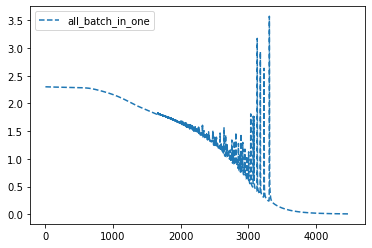

In [98]:
# loss[10]
plt.plot(range(4500),loss[10],label="all_batch_in_one",linestyle='dashed')
plt.legend()
plt.show()

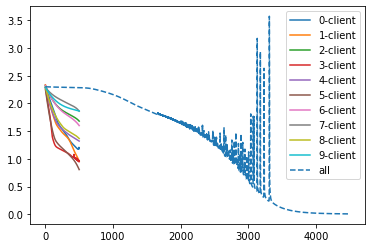

In [100]:
plt.plot(range(500),loss[0],label="0-client")
plt.plot(range(500),loss[1],label="1-client")
plt.plot(range(500),loss[2],label="2-client")
plt.plot(range(500),loss[3],label="3-client")
plt.plot(range(500),loss[4],label="4-client")
plt.plot(range(500),loss[5],label="5-client")
plt.plot(range(500),loss[6],label="6-client")
plt.plot(range(500),loss[7],label="7-client")
plt.plot(range(500),loss[8],label="8-client")
plt.plot(range(500),loss[9],label="9-client")
plt.plot(range(4500),loss[10],label="all",linestyle='dashed')
plt.legend(loc=1)
# plt.savefig("./ten_client_one_batch_256.png",dpi=330)
plt.show()

In [67]:
device = 'cuda'
train_dl_global, test_dl_global, _, _ = get_dataloader("cifar10", './', 256, 32)
train_acc_li = []
test_acc_li = []
train_acc0, train_loss0 = compute_accuracy(net0, train_dl_global, device=device)
test_acc0, test_loss0 = compute_accuracy(net0, test_dl_global, device=device)
for i in range(10):
    train_acc, train_loss = compute_accuracy(nets[i], train_dl_global, device=device)
    test_acc, test_loss = compute_accuracy(nets[i], test_dl_global, device=device)
    train_acc_li.append(train_acc)
    test_acc_li.append(test_acc)

train_acc_li.append(train_acc0)
test_acc_li.append(test_acc0)
train_acc_li

[0.12890625,
 0.1345352564102564,
 0.10004006410256411,
 0.11975160256410257,
 0.10943509615384615,
 0.12061298076923077,
 0.10679086538461538,
 0.10072115384615385,
 0.10400641025641026,
 0.09997996794871795,
 0.10004006410256411]

In [101]:
train_acc0, train_loss0 = compute_accuracy(net0, train_dl_global, device=device)
test_acc0, test_loss0 = compute_accuracy(net0, test_dl_global, device=device)


In [102]:
train_acc_li[10]=train_acc0
test_acc_li[10]=test_acc0

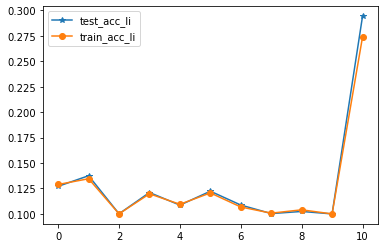

In [96]:
plt.plot(range(11),test_acc_li,label="test_acc_li",marker='*')
plt.plot(range(11),train_acc_li,label="train_acc_li",marker='o')
plt.legend()
# plt.savefig("./with_avg.png",dpi=330)
plt.show()


## original

In [160]:
agg = torch.concat((x0,x1))
agg.shape
agg_target = torch.concat((y0,y1))
agg_target

net0=copy.deepcopy(net_global)
net1=copy.deepcopy(net_global)
net2=copy.deepcopy(net_global)
net3=copy.deepcopy(net_global)
lr=0.01
optimizer_0 = optim.SGD(filter(lambda p: p.requires_grad, net0.parameters()), lr=lr, weight_decay=1e-5)
optimizer_1 = optim.SGD(filter(lambda p: p.requires_grad, net1.parameters()), lr=lr, weight_decay=1e-5)
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, net2.parameters()), lr=lr,weight_decay=1e-5)
li_loss0 = []
li_loss1 = []
li_loss2 = []
li_loss = []
for i in range(1000):
    _,_,out0 = net0(agg)
    loss_0= criterion(out0,agg_target)
    li_loss0.append(loss_0.data)

    optimizer_0.zero_grad()
    loss_0.backward()
    optimizer_0.step()

    _,_,out1 = net1(x0)
    loss_1= criterion(out1,y0)
    li_loss1.append(loss_1.data)

    _,_,out2 = net2(x1)
    loss_2= criterion(out2,y1)
    li_loss2.append(loss_2.data)

#     with torch.no_grad():
#         loss = torch.div(loss_1+loss_2,2)
#     li_loss.append(loss.data)

#     with torch.no_grad():
#         loss_1.set_(loss)

#     with torch.no_grad():
#         loss_2.set_(loss)
        
    optimizer_1.zero_grad()
    loss_1.backward()
    optimizer_1.step()
    
    optimizer_2.zero_grad()
    loss_2.backward()
    optimizer_2.step()

In [157]:
# [i-j for i,j in zip(li_loss,li_loss0)]

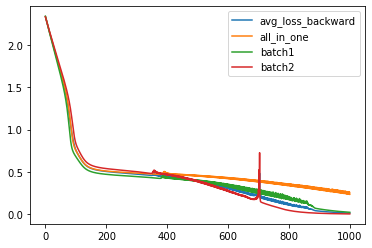

In [159]:
plt.plot(range(1000),li_loss,label="avg_loss_backward")
plt.plot(range(1000),li_loss0,label="all_in_one")
plt.plot(range(1000),li_loss1,label="batch1")
plt.plot(range(1000),li_loss2,label="batch2")
plt.legend()
# plt.savefig("./with_avg.png",dpi=330)
plt.show()

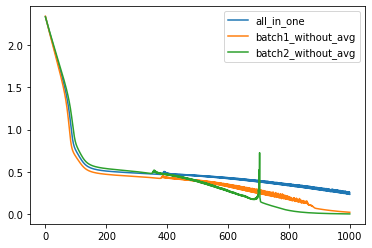

In [161]:
plt.plot(range(1000),li_loss0,label="all_in_one")
plt.plot(range(1000),li_loss1,label="batch1_without_avg")
plt.plot(range(1000),li_loss2,label="batch2_without_avg")
plt.legend()
# plt.savefig("./without_avg.png",dpi=330)
plt.show()

In [173]:
agg_target.shape

torch.Size([64])

In [174]:
y0.shape

torch.Size([32])

In [175]:
y1.shape

torch.Size([32])

In [176]:
_,_,out0 = net0(agg)
criterion(out0,agg_target)

tensor(7.9264, grad_fn=<NllLossBackward0>)

In [177]:
_,_,out1 = net1(agg)
criterion(out1,agg_target)

tensor(11.6212, grad_fn=<NllLossBackward0>)

In [178]:
_,_,out2 = net2(agg)
criterion(out2,agg_target)

tensor(13.8740, grad_fn=<NllLossBackward0>)

In [185]:
device = 'cpu'
# train_acc, train_loss = compute_accuracy(global_model, train_dl_global, device=device)
test_acc, conf_matrix, _ = compute_accuracy(net2, test_dl_local, get_confusion_matrix=True, device=device)

In [186]:
test_acc

0.1235

In [187]:
conf_matrix

array([[797, 203,   0,   0,   0,   0,   0,   0,   0,   0],
       [562, 438,   0,   0,   0,   0,   0,   0,   0,   0],
       [639, 361,   0,   0,   0,   0,   0,   0,   0,   0],
       [577, 423,   0,   0,   0,   0,   0,   0,   0,   0],
       [633, 367,   0,   0,   0,   0,   0,   0,   0,   0],
       [680, 320,   0,   0,   0,   0,   0,   0,   0,   0],
       [485, 515,   0,   0,   0,   0,   0,   0,   0,   0],
       [743, 257,   0,   0,   0,   0,   0,   0,   0,   0],
       [650, 350,   0,   0,   0,   0,   0,   0,   0,   0],
       [550, 450,   0,   0,   0,   0,   0,   0,   0,   0]])

In [74]:
# im = Image.fromarray(X[0].numpy()).resize((256,256), Image.ANTIALIAS)
# im

In [75]:
# cifar_dataobj = CIFAR10("./", True, None, None, False)

In [76]:
# cifar_dataobj.data[0].shape

In [77]:
# im = Image.fromarray(cifar_dataobj.data[0]).resize((256,256), Image.ANTIALIAS)
# im

In [86]:
# y=cifar_dataobj.targets[0]
# y

In [87]:
# net(cifar_dataobj.data[0])
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
#   
# tensor = transform(X[0].numpy())

In [149]:
ll = []
for i in range(len(X)):
    _,_,y_=net(X[i])
    loss = criterion(y_, Y[i])
    ll.append(loss)
ll
print(sum(ll))

tensor(148.5636, grad_fn=<AddBackward0>)


In [150]:
sum(ll)/64

tensor(2.3213, grad_fn=<DivBackward0>)

In [179]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr,
                              weight_decay=1e-5)
criterion = nn.CrossEntropyLoss() # .cuda()

In [198]:
x, target = X, Y
x.requires_grad = False
target.requires_grad = False
target = target.long()
_,_,out = net(x)
loss = criterion(out, target)
loss.backward()
optimizer.zero_grad()
optimizer.step()
loss

tensor(2.3078, grad_fn=<NllLossBackward0>)

In [199]:
_,_,out = net(x)
loss = criterion(out, target)
loss

tensor(2.3097, grad_fn=<NllLossBackward0>)

In [159]:
X.requires_grad = False
Y.requires_grad = False
Y = Y.long()
for i in range(len(X)):
    _,_,y_=net(X[i])
    loss = criterion(y_, Y[i])
    print(loss)a
#     with torch.no_grad():
#         loss.set_(torch.Tensor([10])[0])
#     print(loss)
    loss.backward()
    optimizer.zero_grad()
    optimizer.step()

tensor(2.2965, grad_fn=<NllLossBackward0>)
tensor(2.3362, grad_fn=<NllLossBackward0>)
tensor(2.3400, grad_fn=<NllLossBackward0>)
tensor(2.3651, grad_fn=<NllLossBackward0>)
tensor(2.2963, grad_fn=<NllLossBackward0>)
tensor(2.3354, grad_fn=<NllLossBackward0>)
tensor(2.3349, grad_fn=<NllLossBackward0>)
tensor(2.2943, grad_fn=<NllLossBackward0>)
tensor(2.2961, grad_fn=<NllLossBackward0>)
tensor(2.3358, grad_fn=<NllLossBackward0>)
tensor(2.3602, grad_fn=<NllLossBackward0>)
tensor(2.3369, grad_fn=<NllLossBackward0>)
tensor(2.2987, grad_fn=<NllLossBackward0>)
tensor(2.2990, grad_fn=<NllLossBackward0>)
tensor(2.2928, grad_fn=<NllLossBackward0>)
tensor(2.2903, grad_fn=<NllLossBackward0>)
tensor(2.3377, grad_fn=<NllLossBackward0>)
tensor(2.2992, grad_fn=<NllLossBackward0>)
tensor(2.2868, grad_fn=<NllLossBackward0>)
tensor(2.3558, grad_fn=<NllLossBackward0>)
tensor(2.3402, grad_fn=<NllLossBackward0>)
tensor(2.2929, grad_fn=<NllLossBackward0>)
tensor(2.2981, grad_fn=<NllLossBackward0>)
tensor(2.33